In [1]:
!pip install catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE, SVMSMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
RocCurveDisplay
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
sns.set(style="dark")

# Read data

In [2]:
df_churn = pd.read_csv('/content/churn-bigml-80.csv')
df_churn.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


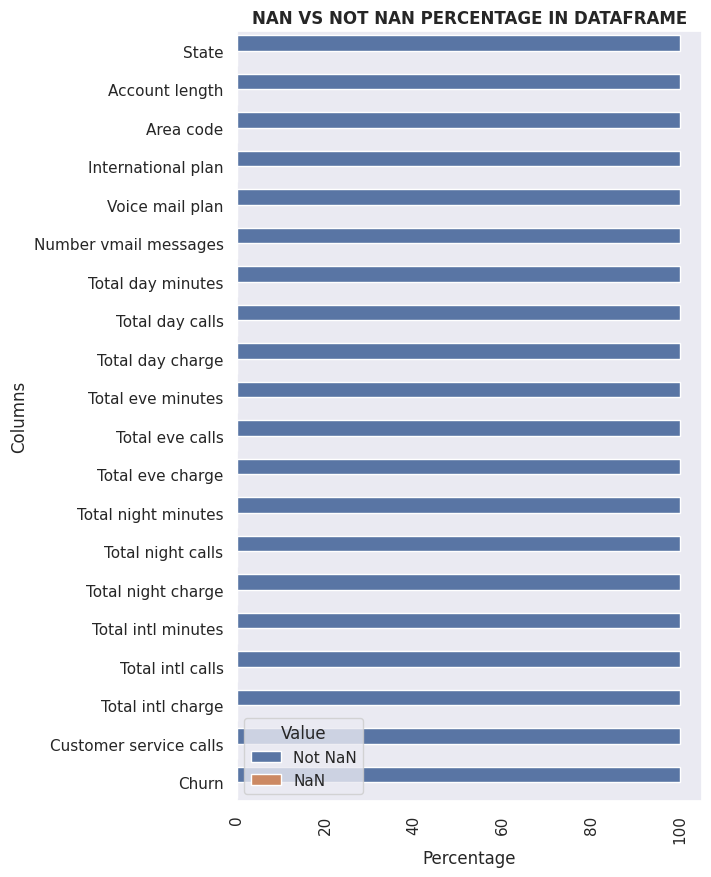

In [3]:
# Check Nan/ NoN-Nan

# Calculate the percentage of NaN and non-NaN in each column
total_counts = len(df_churn)
nan_percentages = (df_churn.isna().sum() / total_counts) * 100
not_nan_percentages = (df_churn.notna().sum() / total_counts) * 100

# Create DataFrame from calculated data
percentages_df = pd.DataFrame({'Columns': nan_percentages.index, 'Not NaN': not_nan_percentages.values, 'NaN': nan_percentages.values})

# Convert DataFrame format from wide to long to draw the chart
percentages_df = percentages_df.melt(id_vars=['Columns'], var_name='Value', value_name='Percentage')

# Plot
plt.figure(figsize=(6, 10))
sns.barplot(data=percentages_df, y='Columns', x='Percentage', hue='Value')
plt.xlabel('Percentage')
plt.ylabel('Columns')
plt.title('NAN VS NOT NAN PERCENTAGE IN DATAFRAME',fontsize=12, fontweight='bold')
plt.xticks(rotation=90)
plt.legend(title='Value')
plt.show()


In [4]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

# EDA

In [5]:
df_churn.head(2)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


In [6]:
# Rename columns to lowercase and spaces to '_'
df_churn = df_churn.rename(columns=lambda x: x.lower().replace(' ', '_'))
df_churn.head(2)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


## Churn rate

In [7]:
df_churn['churn'].value_counts().to_frame()

,churn
False,2278
True,388


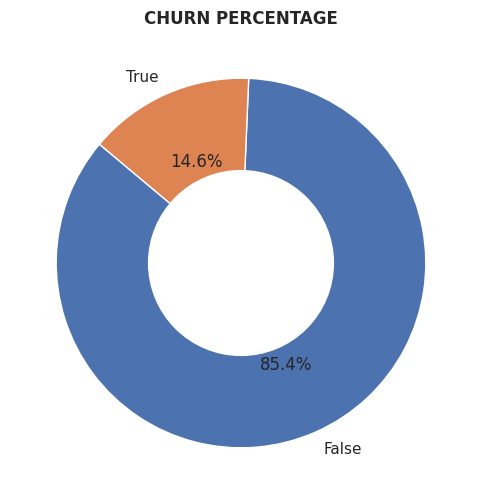

In [8]:
# Calculate percentage for each group in the chart
percentages = df_churn['churn'].value_counts(normalize=True) * 100

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=140)
ax.set_title('CHURN PERCENTAGE', fontsize=12, fontweight='bold')

# Add centre_circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig.gca().add_artist(centre_circle)

plt.show()


* Customers not leaving the service (False) account for 85.4%
*
Customers leaving the service (True) account for 14.6. <br>
=>**The churn rate is low but noteworthy** with 14.6% of customers leaving. This may indicate that most customers continue to use your service.



## State

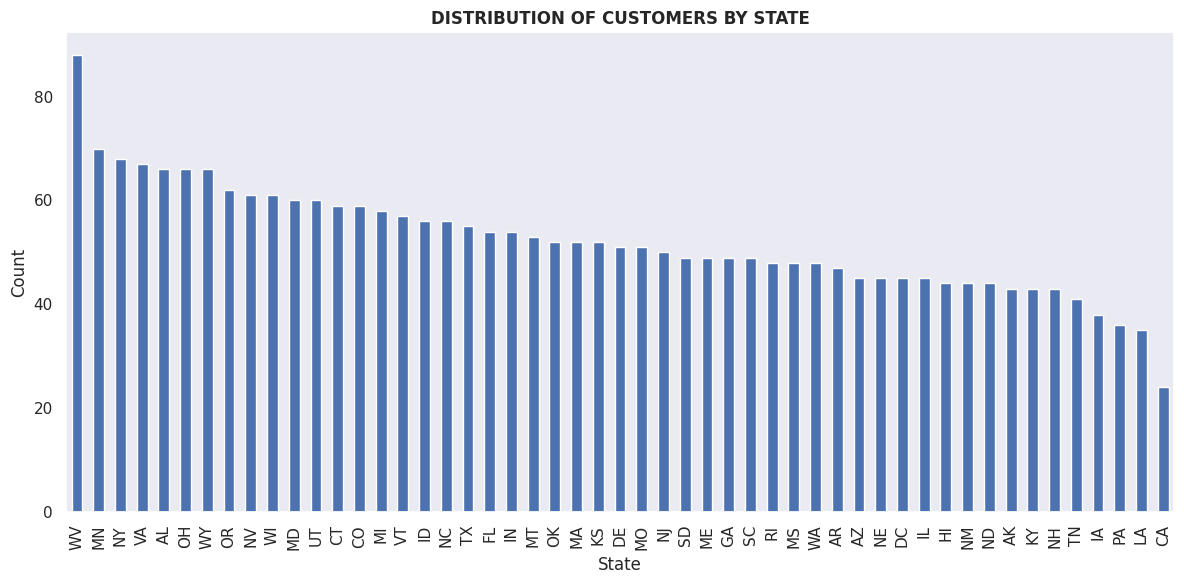

In [9]:
# Get the count of each value in column 'state'
state_counts = df_churn['state'].value_counts().sort_values(ascending = False)

# Plot
plt.figure(figsize=(12, 6))
state_counts.plot(kind='bar')
plt.title('DISTRIBUTION OF CUSTOMERS BY STATE',fontsize=12, fontweight='bold')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Account length

In [10]:
# Check the engagement time of churning and non-churning customers
quantiles = df_churn.groupby('churn')['account_length'].quantile([0.25, 0.5, 0.75])
quantiles

churn      
False  0.25     73.00
       0.50    100.00
       0.75    127.00
True   0.25     75.75
       0.50    103.00
       0.75    127.00
Name: account_length, dtype: float64

<ipython-input-11-61bf28f62df3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_churn, x= 'churn', y='account_length', showfliers= False, showmeans = 'True', palette = 'deep')


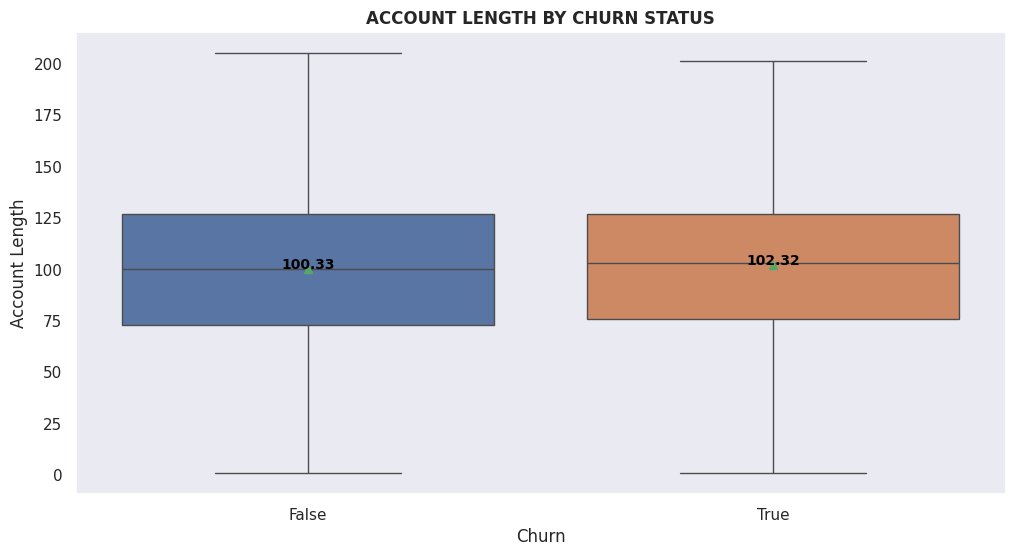

In [11]:
plt.figure(figsize=(12, 6))
mean_values = df_churn.groupby('churn')['account_length'].mean()
sns.boxplot(data = df_churn, x= 'churn', y='account_length', showfliers= False, showmeans = 'True', palette = 'deep')
# Show specific mean value on boxplot
for i, mean_value in enumerate(mean_values):
    plt.text(i, mean_value, f'{mean_value:.2f}', color='black', ha="center", fontsize=10, fontweight='bold')
plt.xlabel('Churn')
plt.ylabel('Account Length')
plt.title('ACCOUNT LENGTH BY CHURN STATUS',fontsize=12, fontweight='bold' )
plt.show()

In [12]:
df_churn_false = df_churn[(df_churn["churn"] == False)]
df_churn_true = df_churn[(df_churn["churn"] == True)]

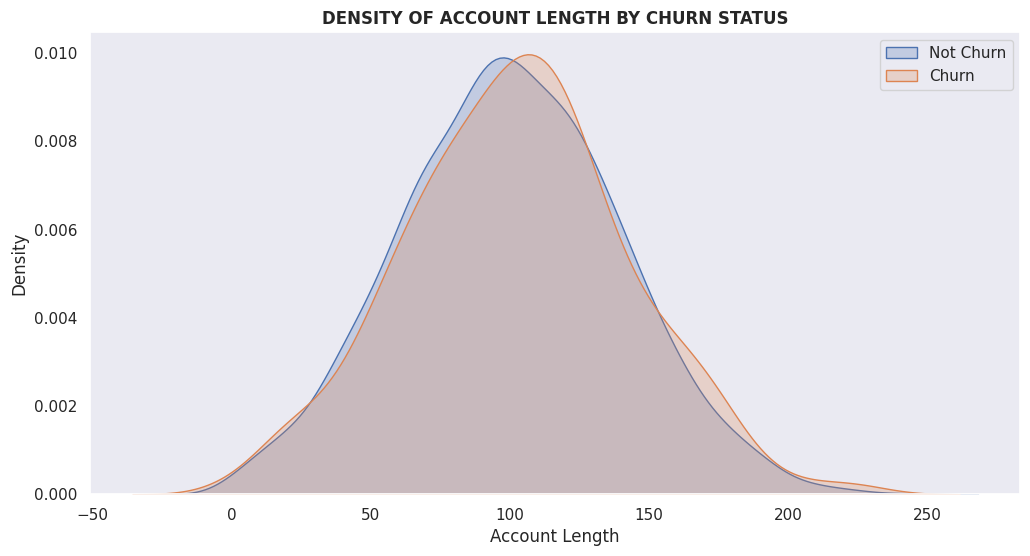

In [13]:
plt.figure(figsize=(12, 6))
# Set color for distributions
ax = sns.kdeplot(df_churn_false['account_length'],
                 color="#4c72b0",
                 fill=True);
ax = sns.kdeplot(df_churn_true['account_length'],
                 ax=ax,
                 color="#dd8452",
                 fill=True);
ax.legend(["Not Churn", "Churn"], loc='upper right');
# Name the chart and axis
plt.title('DENSITY OF ACCOUNT LENGTH BY CHURN STATUS',fontsize=12, fontweight='bold')
plt.ylabel('Density')
plt.xlabel('Account Length')
plt.show()

## Area Code

### Distribution

In [14]:
df_churn['area_code'].value_counts().to_frame()

,area_code
415,1318
510,679
408,669


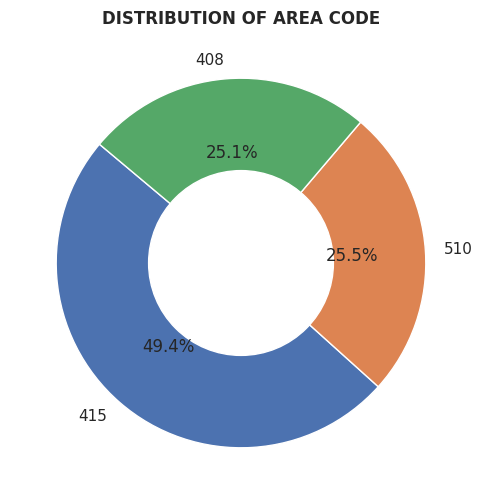

In [15]:

percentages = df_churn['area_code'].value_counts(normalize=True) * 100

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=140)
ax.set_title('DISTRIBUTION OF AREA CODE', fontsize=12, fontweight='bold')


centre_circle = plt.Circle((0,0),0.50,fc='white')
fig.gca().add_artist(centre_circle)

plt.show()

### Churn rate by Area Code

In [16]:
df_churn.groupby(['churn', 'area_code']).size().unstack()

area_code,408,415,510
churn,,,
False,575,1123,580
True,94,195,99


In [17]:

# Calculate the percentage for each group in the chart
percentages = df_churn.groupby(['churn', 'area_code']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1)

# Convert data into long format
percentages = percentages.reset_index().melt(id_vars=['churn'], value_name='Percentage', var_name='Area Code')

# Create a new color palette
# color_map = {415: '#4C72B0FF', 408: '#Đ8452FF', 510:'#55A868FF'}
color_map = {415: '#3B5998', 408: '#007200', 510:'#CC6600'}

# Draw a column chart stacked with percentages and specify colors
fig = px.bar(percentages, x='churn', y='Percentage', color='Area Code', barmode='stack',
             title='AREA CODE BY CHURN',
             color_discrete_map=color_map)
fig.update_layout(width=700, height=500, colorway=px.colors.qualitative.Plotly)


fig.show()


## International Plan

### Distribution

In [18]:
df_churn['international_plan'].value_counts().to_frame()

,international_plan
No,2396
Yes,270


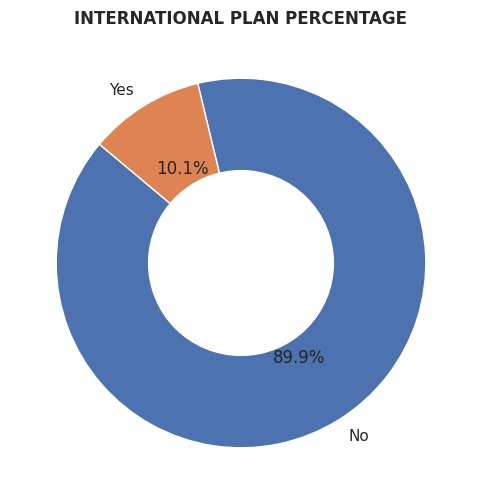

In [19]:

percentages = df_churn['international_plan'].value_counts(normalize=True) * 100


fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=140)
ax.set_title('INTERNATIONAL PLAN PERCENTAGE', fontsize=12, fontweight='bold')

centre_circle = plt.Circle((0,0),0.50,fc='white')
fig.gca().add_artist(centre_circle)

plt.show()

### Churn rate by International Plan

In [20]:
df_churn.groupby(by=['churn','international_plan'])['state'].count().unstack()

international_plan,No,Yes
churn,,
False,2126,152
True,270,118


In [21]:

percentages = df_churn.groupby(['churn', 'international_plan']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1)

percentages = percentages.reset_index().melt(id_vars=['churn'], value_name='Percentage', var_name='International Plan')

color_map = { 'No': '#3B5998', 'Yes':'#CC6600'}

fig = px.bar(percentages, x='churn', y='Percentage', color='International Plan', barmode='stack', color_discrete_map=color_map,
             title='CHURN BY INTERNATIONAL PLAN DISTRIBUTION')
fig.update_layout(width=700, height=500)
fig.show()


## Voice Mail Plan

### Distribution

In [22]:
df_churn['voice_mail_plan'].value_counts().to_frame()

,voice_mail_plan
No,1933
Yes,733


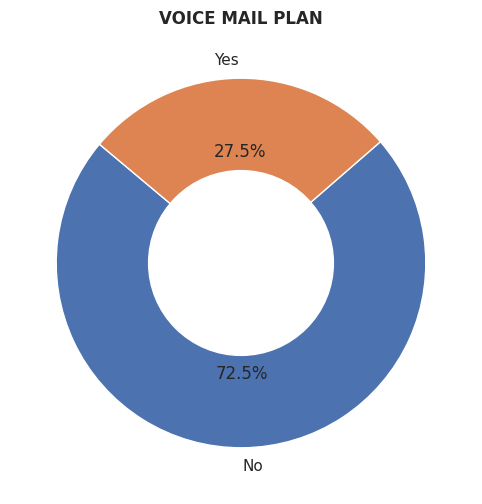

In [23]:

percentages = df_churn['voice_mail_plan'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=140)
ax.set_title('VOICE MAIL PLAN', fontsize=12, fontweight='bold')

centre_circle = plt.Circle((0,0),0.50,fc='white')
fig.gca().add_artist(centre_circle)

plt.show()

### Churn rate by Voice Mail Plan

In [24]:
df_churn.groupby(by=['churn','voice_mail_plan'])['state'].count().unstack()

voice_mail_plan,No,Yes
churn,,
False,1610,668
True,323,65


In [25]:

percentages = df_churn.groupby(['churn', 'voice_mail_plan']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1)


percentages = percentages.reset_index().melt(id_vars=['churn'], value_name='Percentage', var_name='Voice Mail Plan')


fig = px.bar(percentages, x='churn', y='Percentage', color='Voice Mail Plan', barmode='stack',
             title='CHURN BY VOICE MAIL PLAN DISTRIBUTION')
fig.update_layout(width=700, height=500)
fig.show()


## Number Vmail Messages

### Distribution

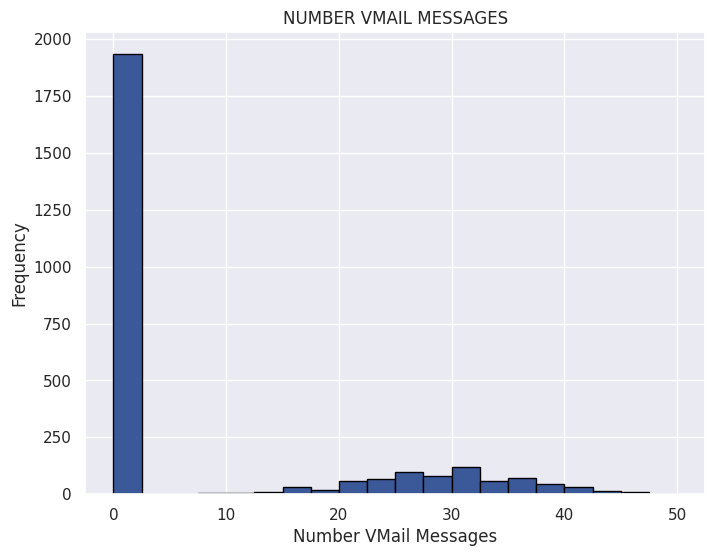

In [26]:
plt.figure(figsize=(8, 6))
plt.hist(df_churn['number_vmail_messages'], bins=20, color='#3B5998', edgecolor='black')
plt.title('NUMBER VMAIL MESSAGES')
plt.xlabel('Number VMail Messages')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Churn rate by Number VMail Messages

<ipython-input-27-b45615c182b3>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




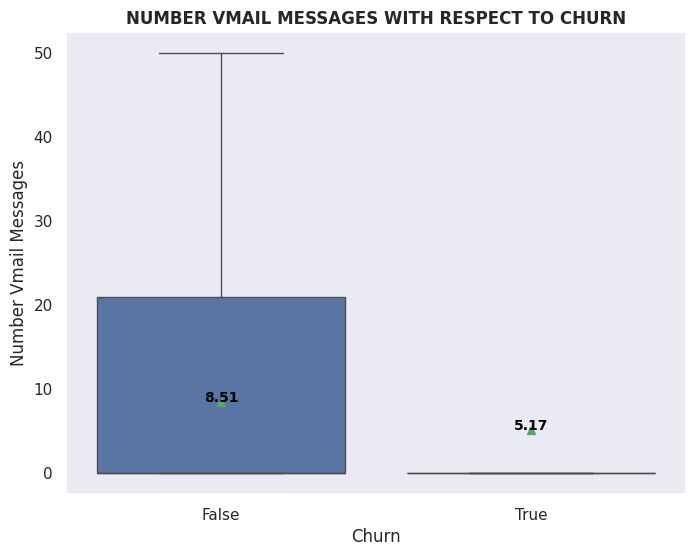

In [27]:
plt.figure(figsize=(8, 6))
mean_vmail_messages = df_churn.groupby('churn')['number_vmail_messages'].mean()
sns.boxplot(data = df_churn, x= 'churn', y='number_vmail_messages', showfliers = False, showmeans = 'True', palette = 'deep')
for i, mean_vmail_message in enumerate(mean_vmail_messages):
    plt.text(i, mean_vmail_message, f'{mean_vmail_message:.2f}', color='black', ha="center", fontsize=10, fontweight='bold')
plt.title('NUMBER VMAIL MESSAGES WITH RESPECT TO CHURN',fontsize=12, fontweight='bold')
plt.xlabel('Churn')
plt.ylabel('Number Vmail Messages')
plt.show()

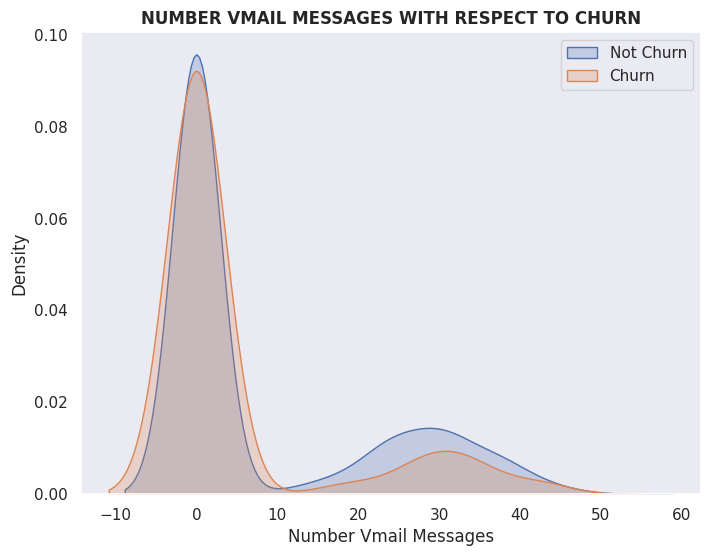

In [28]:
plt.figure(figsize=(8, 6))
# Set color for distributions
ax = sns.kdeplot(df_churn_false['number_vmail_messages'],
                 color="#4c72b0",
                 fill=True);
ax = sns.kdeplot(df_churn_true['number_vmail_messages'],
                 ax=ax,
                 color="#dd8452",
                 fill=True);
ax.legend(["Not Churn", "Churn"], loc='upper right');

plt.title('NUMBER VMAIL MESSAGES WITH RESPECT TO CHURN',fontsize=12, fontweight='bold')
plt.xlabel('Number Vmail Messages')
plt.ylabel('Density')
plt.show()

## Total Day Minutes - Total eve minutes -  Total night minutes - Total intl minutes

### Distribution

In [29]:
df_churn.head(2)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


In [30]:
df_day_minutes = df_churn[['total_day_minutes', 'churn']].rename(columns = {'total_day_minutes':'values'})
df_day_minutes['category'] = 'Total Day Minutes'

df_eve_minutes = df_churn[['total_eve_minutes', 'churn']].rename(columns = {'total_eve_minutes':'values'})
df_eve_minutes['category'] = 'Total Eve Minutes'

df_night_minutes = df_churn[['total_night_minutes', 'churn']].rename(columns = {'total_night_minutes':'values'})
df_night_minutes['category'] = 'Total Night Minutes'

df_intl_minutes = df_churn[['total_intl_minutes', 'churn']].rename(columns = {'total_intl_minutes':'values'})
df_intl_minutes['category'] = 'Total Intl Minutes'

df_minutes = pd.concat([df_day_minutes, df_eve_minutes, df_night_minutes, df_intl_minutes])
df_minutes.head(2)

,values,churn,category
0,265.1,False,Total Day Minutes
1,161.6,False,Total Day Minutes


In [31]:
df_minutes.groupby(by=['category','churn'])['values'].mean()

category             churn
Total Day Minutes    False    175.104346
                     True     205.181186
Total Eve Minutes    False    198.853380
                     True     209.385309
Total Intl Minutes   False     10.137840
                     True      10.819330
Total Night Minutes  False    200.464091
                     True     205.307216
Name: values, dtype: float64

<ipython-input-32-d3250d06734e>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




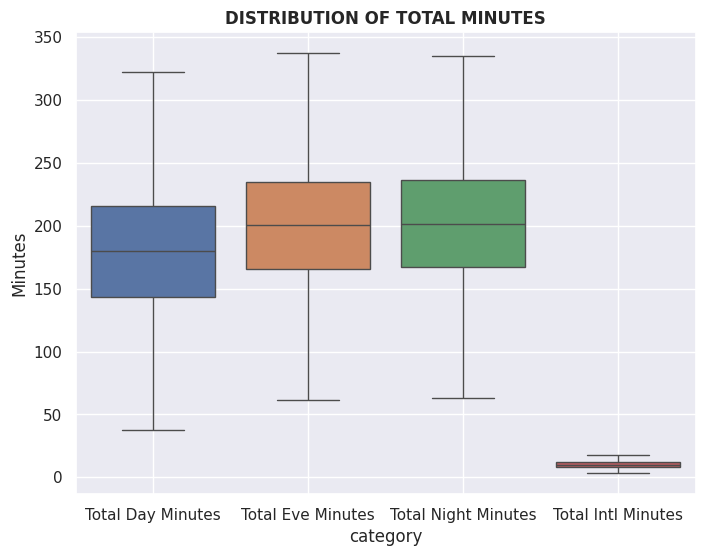

In [32]:
plt.figure(figsize=(8, 6))
sns.boxplot(data =df_minutes, x= 'category', y ='values' , showfliers = False, palette = 'deep')
plt.title('DISTRIBUTION OF TOTAL MINUTES', fontsize=12, fontweight='bold')
plt.ylabel('Minutes')
plt.grid(True)
plt.show()

### Churn rate by Total Day Minutes

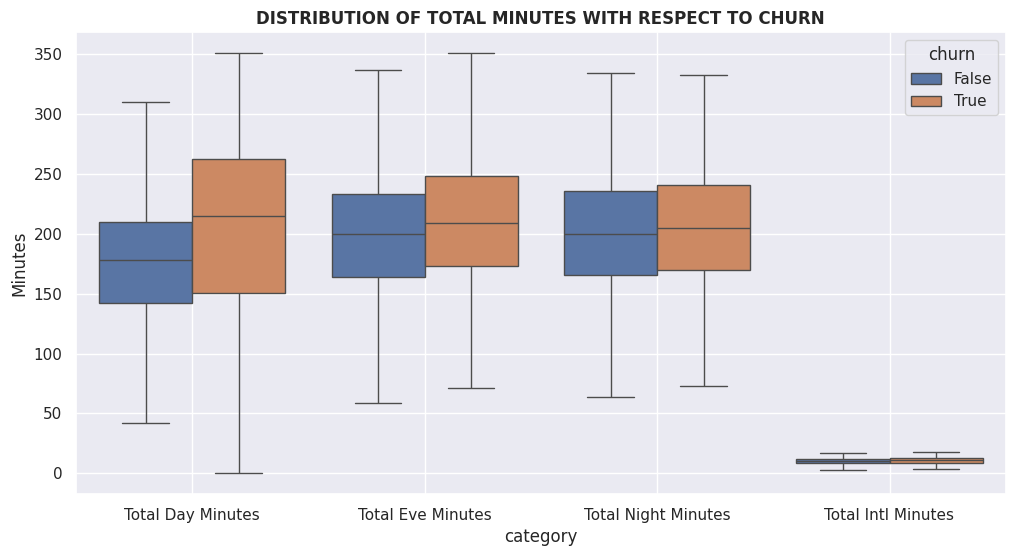

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(data =df_minutes, x= 'category', y ='values' , hue = 'churn', showfliers = False)
plt.title('DISTRIBUTION OF TOTAL MINUTES WITH RESPECT TO CHURN', fontsize=12, fontweight='bold')
plt.ylabel('Minutes')
plt.grid(True)
plt.show()

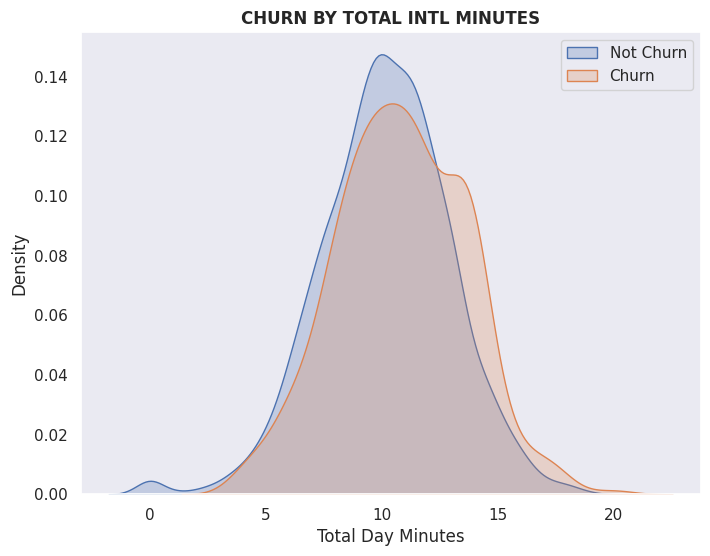

In [34]:
plt.figure(figsize=(8, 6))

ax = sns.kdeplot(df_churn_false['total_intl_minutes'],
                 color="#4c72b0",
                 fill=True);
ax = sns.kdeplot(df_churn_true['total_intl_minutes'],
                 ax=ax,
                 color="#dd8452",
                 fill=True);
ax.legend(["Not Churn", "Churn"], loc='upper right');

plt.title('CHURN BY TOTAL INTL MINUTES',fontsize=12, fontweight='bold')
plt.ylabel('Density')
plt.xlabel('Total Day Minutes')
plt.show()

## Total Day Calls - Total eve calls -  Total night calls -  Total intl calls

### Distribution

In [35]:
df_day_calls = df_churn[['total_day_calls', 'churn']].rename(columns = {'total_day_calls':'values'})
df_day_calls['category'] = 'Total Day Calls'

df_eve_calls = df_churn[['total_eve_calls', 'churn']].rename(columns = {'total_eve_calls':'values'})
df_eve_calls['category'] = 'Total Eve Calls'

df_night_calls = df_churn[['total_night_calls', 'churn']].rename(columns = {'total_night_calls':'values'})
df_night_calls['category'] = 'Total Night Calls'

df_intl_calls = df_churn[['total_intl_calls', 'churn']].rename(columns = {'total_intl_calls':'values'})
df_intl_calls['category'] = 'Total Intl Calls'

df_calls = pd.concat([df_day_calls, df_eve_calls, df_night_calls, df_intl_calls])
df_calls.head(2)

,values,churn,category
0,110,False,Total Day Calls
1,123,False,Total Day Calls


<ipython-input-36-e1166100177d>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




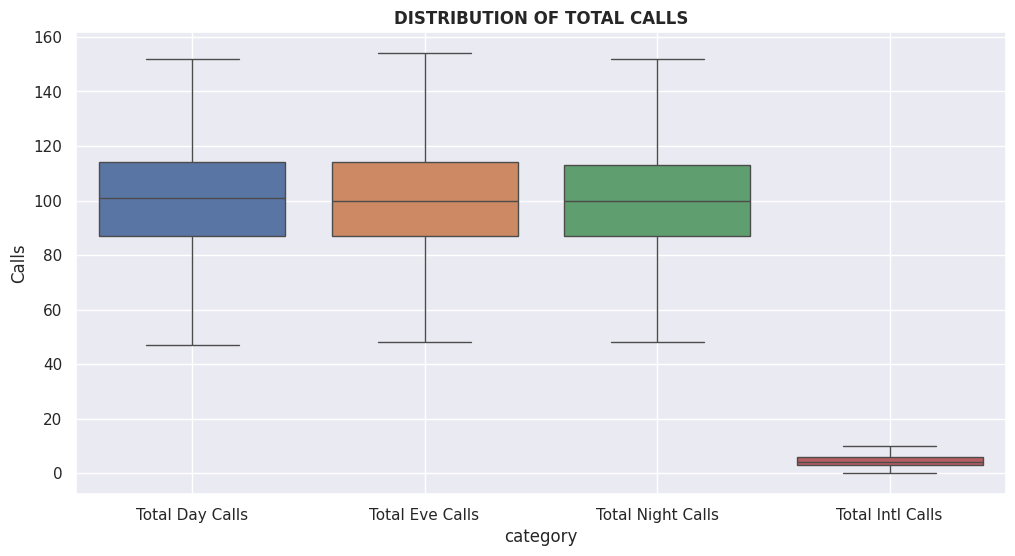

In [36]:
plt.figure(figsize=(12, 6))
sns.boxplot(data =df_calls, x= 'category', y ='values' , showfliers = False, palette = 'deep')
plt.title('DISTRIBUTION OF TOTAL CALLS', fontsize=12, fontweight='bold')
plt.ylabel('Calls')
plt.grid(True)
plt.show()

### Churn rate by Total Day Calls

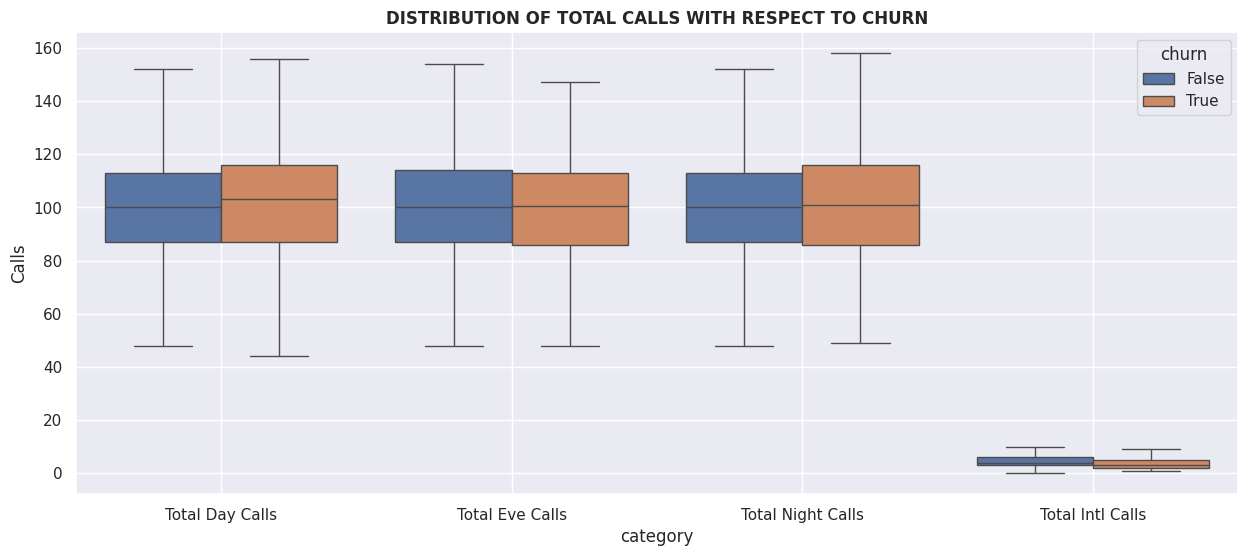

In [37]:
plt.figure(figsize=(15, 6))
sns.boxplot(data =df_calls, x= 'category', y ='values', hue='churn' , showfliers = False)
plt.title('DISTRIBUTION OF TOTAL CALLS WITH RESPECT TO CHURN', fontsize=12, fontweight='bold')
plt.ylabel('Calls')
plt.grid(True)
plt.show()

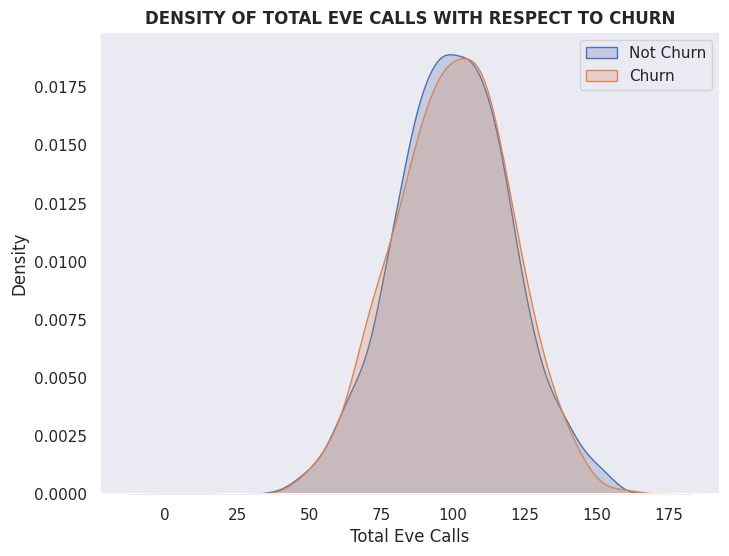

In [38]:
plt.figure(figsize=(8, 6))

ax = sns.kdeplot(df_churn_false['total_eve_calls'],
                 color="#4c72b0",
                 fill=True);
ax = sns.kdeplot(df_churn_true['total_eve_calls'],
                 ax=ax,
                 color="#dd8452",
                 fill=True);
ax.legend(["Not Churn", "Churn"], loc='upper right');

plt.title('DENSITY OF TOTAL EVE CALLS WITH RESPECT TO CHURN',fontsize=12, fontweight='bold')
plt.ylabel('Density')
plt.xlabel('Total Eve Calls')
plt.show()

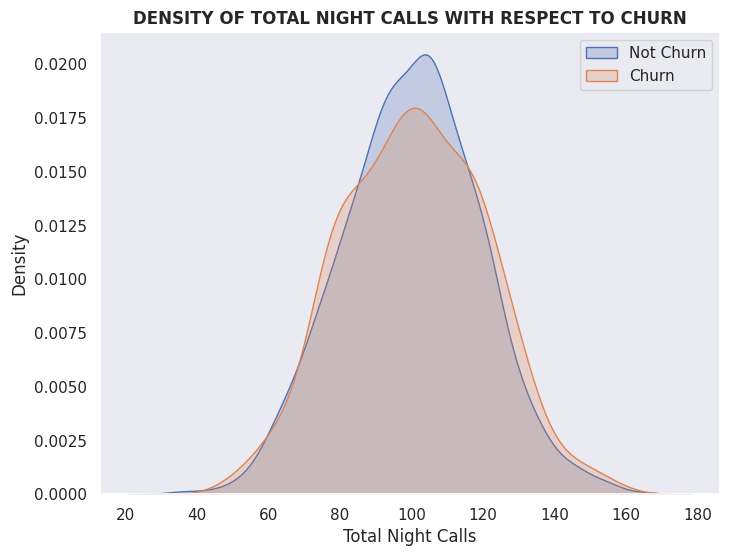

In [39]:
plt.figure(figsize=(8, 6))

ax = sns.kdeplot(df_churn_false['total_night_calls'],
                 color="#4c72b0",
                 fill=True);
ax = sns.kdeplot(df_churn_true['total_night_calls'],
                 ax=ax,
                 color="#dd8452",
                 fill=True);
ax.legend(["Not Churn", "Churn"], loc='upper right');
# Đặt tên cho biểu đồ và trục
plt.title('DENSITY OF TOTAL NIGHT CALLS WITH RESPECT TO CHURN',fontsize=12, fontweight='bold')
plt.ylabel('Density')
plt.xlabel('Total Night Calls')
plt.show()

## Total Day Charge - Total eve charge - Total night charge - Total intl charge

### Distribution

In [40]:
df_day_charge = df_churn[['total_day_charge', 'churn']].rename(columns = {'total_day_charge':'values'})
df_day_charge['category'] = 'Total Day Charge'

df_eve_charge = df_churn[['total_eve_charge', 'churn']].rename(columns = {'total_eve_charge':'values'})
df_eve_charge['category'] = 'Total Eve Charge'

df_night_charge = df_churn[['total_night_charge', 'churn']].rename(columns = {'total_night_charge':'values'})
df_night_charge['category'] = 'Total Night Charge'

df_intl_charge = df_churn[['total_intl_charge', 'churn']].rename(columns = {'total_intl_charge':'values'})
df_intl_charge['category'] = 'Total Intl Charge'

df_charge = pd.concat([df_day_charge, df_eve_charge, df_night_charge, df_intl_charge])
df_charge.head(2)

,values,churn,category
0,45.07,False,Total Day Charge
1,27.47,False,Total Day Charge


<ipython-input-41-1f79dc53e911>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




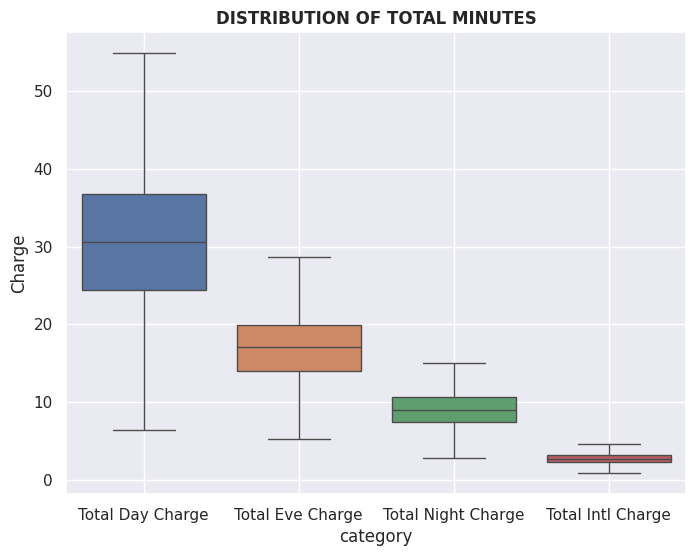

In [41]:
plt.figure(figsize=(8, 6))
sns.boxplot(data =df_charge, x= 'category', y ='values' , showfliers = False, palette = 'deep')
plt.title('DISTRIBUTION OF TOTAL MINUTES', fontsize=12, fontweight='bold')
plt.ylabel('Charge')
plt.grid(True)
plt.show()

### Churn rate by Total Day Charge

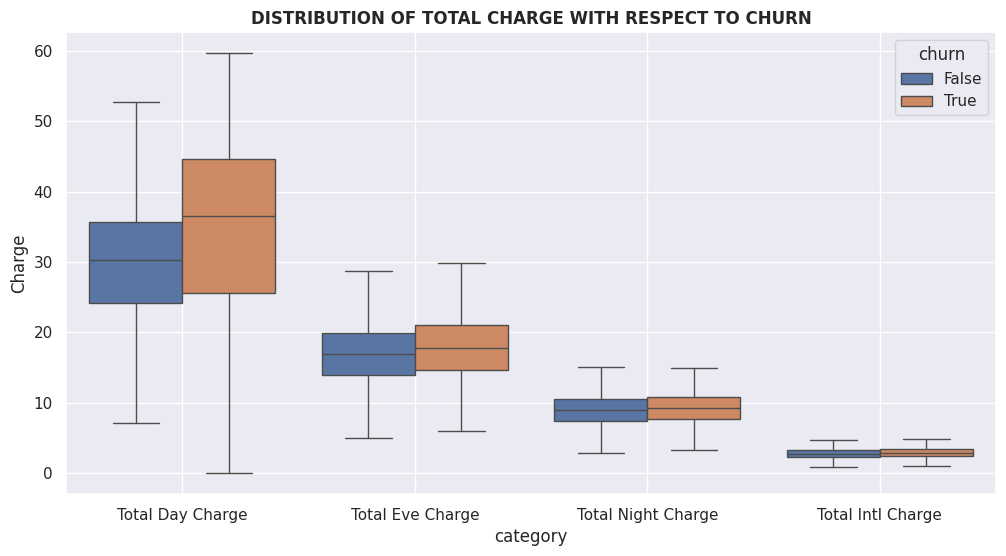

In [42]:
plt.figure(figsize=(12, 6))
sns.boxplot(data =df_charge, x= 'category', y ='values', hue = 'churn', showfliers = False)
plt.title('DISTRIBUTION OF TOTAL CHARGE WITH RESPECT TO CHURN', fontsize=12, fontweight='bold')
plt.ylabel('Charge')
plt.grid(True)
plt.show()

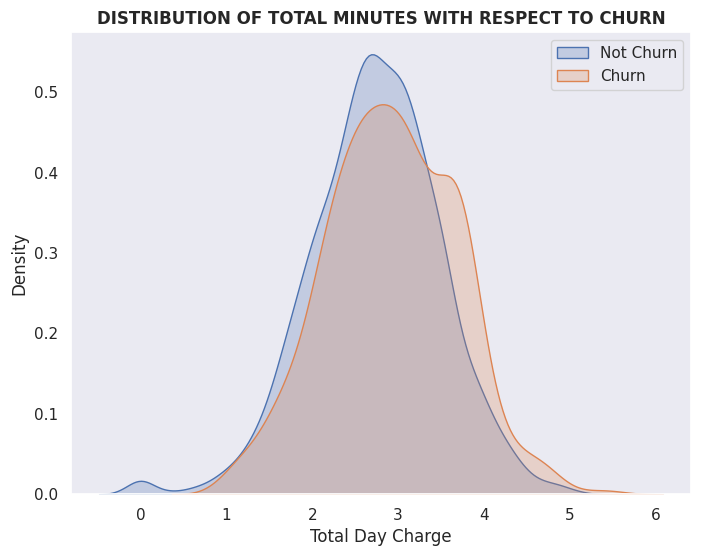

In [43]:
plt.figure(figsize=(8, 6))

ax = sns.kdeplot(df_churn_false['total_intl_charge'],
                 color="#4c72b0",
                 fill=True);
ax = sns.kdeplot(df_churn_true['total_intl_charge'],
                 ax=ax,
                 color="#dd8452",
                 fill=True);
ax.legend(["Not Churn", "Churn"], loc='upper right');

plt.title('DISTRIBUTION OF TOTAL MINUTES WITH RESPECT TO CHURN',fontsize=12, fontweight='bold')
plt.ylabel('Density')
plt.xlabel('Total Day Charge')
plt.show()

## Customer Service Calls

### Distribution

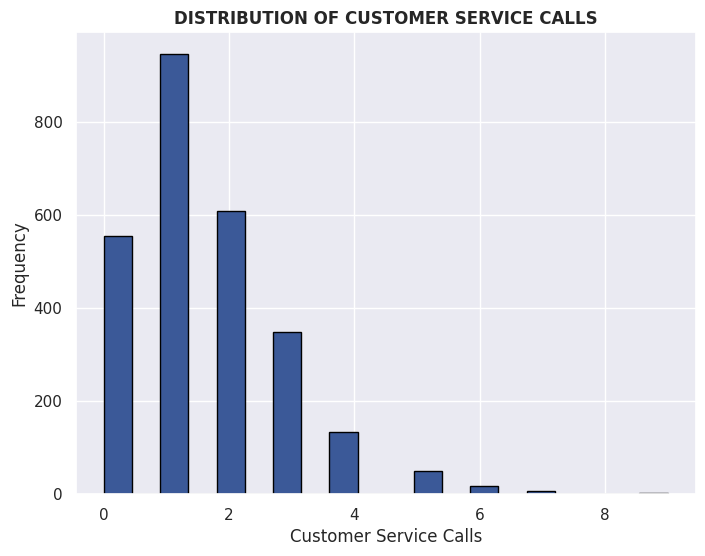

In [44]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(df_churn['customer_service_calls'], bins=20, color='#3B5998', edgecolor='black')
plt.title('DISTRIBUTION OF CUSTOMER SERVICE CALLS', fontsize=12, fontweight='bold')
plt.xlabel('Customer Service Calls')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Churn rate by customer_service_calls

<ipython-input-45-78f8c65ab3ad>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




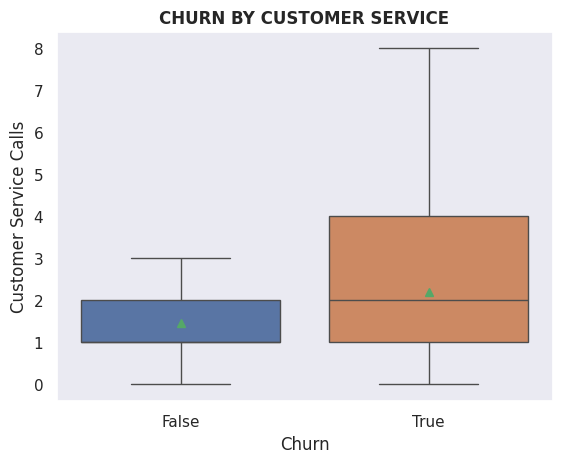

In [45]:
sns.boxplot(data=df_churn, x='churn', y = 'customer_service_calls', showmeans = True, showfliers = False, palette = 'deep')
plt.title('CHURN BY CUSTOMER SERVICE',fontsize=12, fontweight='bold')
plt.xlabel('Churn')
plt.ylabel('Customer Service Calls')
plt.show()

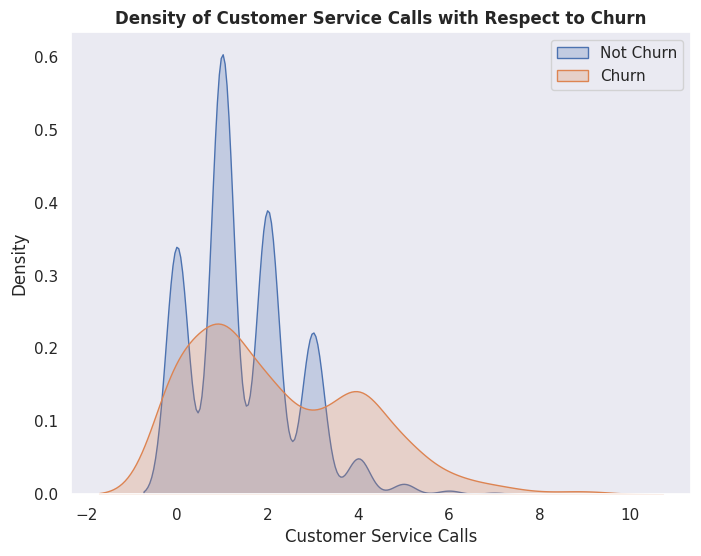

In [46]:
plt.figure(figsize=(8, 6))

ax = sns.kdeplot(df_churn_false['customer_service_calls'],
                 color="#4c72b0",
                 fill=True);
ax = sns.kdeplot(df_churn_true['customer_service_calls'],
                 ax=ax,
                 color="#dd8452",
                 fill=True);
ax.legend(["Not Churn", "Churn"], loc='upper right');

plt.title('Density of Customer Service Calls with Respect to Churn',fontsize=12, fontweight='bold')
plt.ylabel('Density')
plt.xlabel('Customer Service Calls')
plt.show()

# MODEL

## LabelEncoder

In [47]:
col_category =['state','international_plan','voice_mail_plan','churn']

le = LabelEncoder()
for col in col_category:
    df_churn[col+'_encoder'] = le.fit_transform(df_churn[col])

In [48]:
df_churn.head(2)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,state_encoder,international_plan_encoder,voice_mail_plan_encoder,churn_encoder
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False,16,0,1,0
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False,35,0,1,0


## Columns train

In [49]:
train_columns = [ 'account_length', 'area_code', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls', 'state_encoder', 'international_plan_encoder',
       'voice_mail_plan_encoder', 'churn_encoder']
df_train = df_churn[train_columns]
df_train

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,state_encoder,international_plan_encoder,voice_mail_plan_encoder,churn_encoder
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,16,0,1,0
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,35,0,1,0
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,31,0,0,0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,35,1,0,0
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,36,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,79,415,0,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,2,40,0,0,0
2662,192,415,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,3,0,1,0
2663,68,415,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,49,0,0,0
2664,28,510,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,39,0,0,0


## Train model

In [50]:
X = df_train.drop(columns = ['churn_encoder'])
y = df_train['churn_encoder'].values

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 40, stratify=y)

In [52]:
cat = CatBoostClassifier(iterations=1000, learning_rate=0.01, subsample=0.8, depth=10, verbose=0, random_seed=42)
cat.fit(X_train, y_train)

In [53]:
prediction_test = cat.predict(X_test)
print(classification_report(y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       456
           1       0.98      0.71      0.82        78

    accuracy                           0.96       534
   macro avg       0.97      0.85      0.90       534
weighted avg       0.96      0.96      0.95       534



In [54]:
# Compute the prediction on the test set
prediction_test = cat.predict(X_test)

# Print classification report
report = classification_report(y_test, prediction_test, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
0,0.951883,0.997807,0.974304,456.000000
1,0.982143,0.705128,0.820896,78.000000
accuracy,0.955056,0.955056,0.955056,0.955056
macro avg,0.967013,0.851468,0.897600,534.000000
weighted avg,0.956303,0.955056,0.951896,534.000000


<Figure size 1000x600 with 0 Axes>

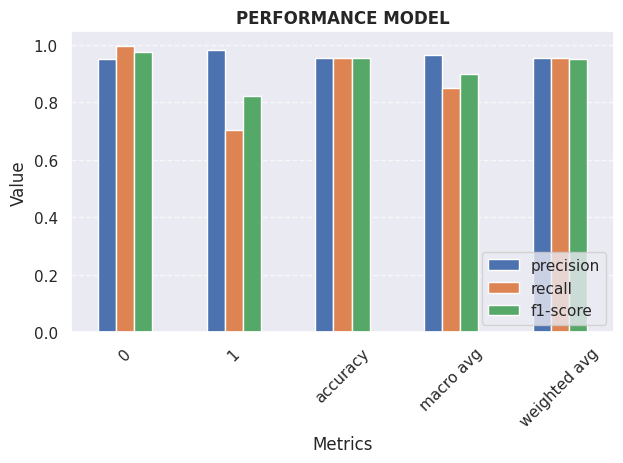

In [55]:
# Draw a column chart
plt.figure(figsize=(10, 6))
df_report.drop('support', axis=1).plot(kind='bar', rot=45)
plt.title('PERFORMANCE MODEL', fontsize=12, fontweight='bold')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

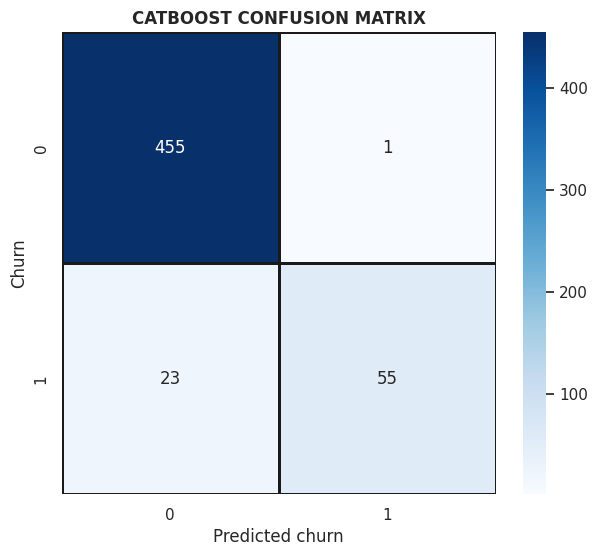

In [56]:
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_matrix(y_test, prediction_test),
            annot=True, fmt="d", linecolor="k", linewidths=1, cmap="Blues")

plt.title("CATBOOST CONFUSION MATRIX", fontsize=12, fontweight='bold')
plt.xlabel('Predicted churn')
plt.ylabel('Churn')
plt.show()

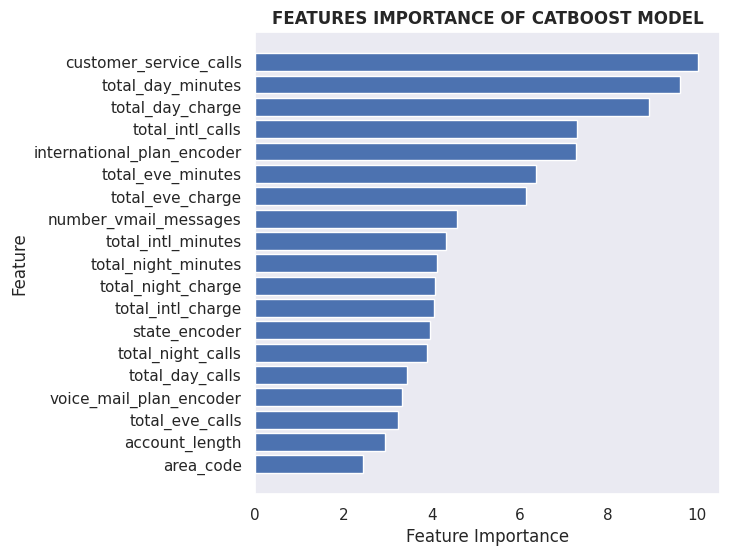

In [57]:
# Get the importance of features from the CatBoost model
feature_importances = cat.get_feature_importance()

# Get the names of the features
cat_fea_imp = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})
cat_fea_imp = cat_fea_imp.sort_values('importance', ascending=False)
# Draw a column chart
plt.figure(figsize=(6, 6))
plt.barh(y=cat_fea_imp['feature'], width=cat_fea_imp['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('FEATURES IMPORTANCE OF CATBOOST MODEL',fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.show()

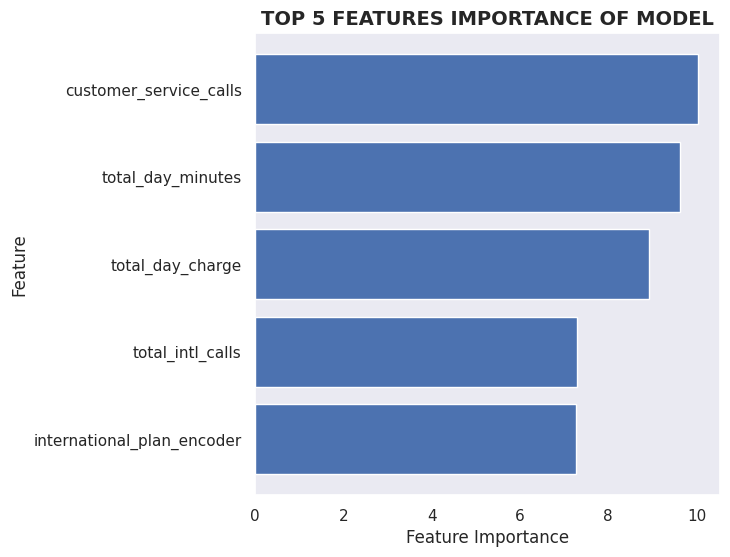

In [58]:
# Select the top 5 most important features
top5_features = cat_fea_imp.head(5)

# Draw a column chart for the top 5 features
plt.figure(figsize=(6, 6))
plt.barh(y=top5_features['feature'], width=top5_features['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('TOP 5 FEATURES IMPORTANCE OF MODEL', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.show()


## Submit

In [59]:
df_test = pd.read_csv('/content/churn-bigml-20.csv')
df_test.shape

(667, 20)

In [60]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   667 non-null    object 
 1   Account length          667 non-null    int64  
 2   Area code               667 non-null    int64  
 3   International plan      667 non-null    object 
 4   Voice mail plan         667 non-null    object 
 5   Number vmail messages   667 non-null    int64  
 6   Total day minutes       667 non-null    float64
 7   Total day calls         667 non-null    int64  
 8   Total day charge        667 non-null    float64
 9   Total eve minutes       667 non-null    float64
 10  Total eve calls         667 non-null    int64  
 11  Total eve charge        667 non-null    float64
 12  Total night minutes     667 non-null    float64
 13  Total night calls       667 non-null    int64  
 14  Total night charge      667 non-null    fl

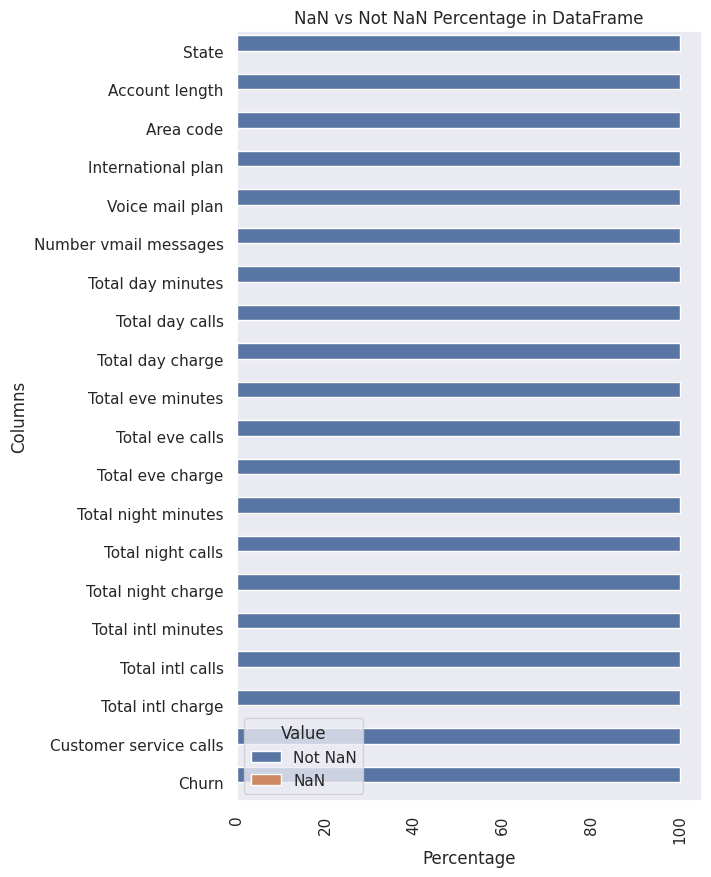

In [61]:
# Calculate the percentage of NaN and non-NaN in each column
total_counts = len(df_test)
nan_percentages = (df_test.isna().sum() / total_counts) * 100
not_nan_percentages = (df_test.notna().sum() / total_counts) * 100

# Create DataFrame from calculated data
percentages_df = pd.DataFrame({'Columns': nan_percentages.index, 'Not NaN': not_nan_percentages.values, 'NaN': nan_percentages.values})

# Convert DataFrame format from wide to long to draw the chart
percentages_df = percentages_df.melt(id_vars=['Columns'], var_name='Value', value_name='Percentage')

# Plot
plt.figure(figsize=(6, 10))
sns.barplot(data=percentages_df, y='Columns', x='Percentage', hue='Value')
plt.xlabel('Percentage')
plt.ylabel('Columns')
plt.title('NaN vs Not NaN Percentage in DataFrame')
plt.xticks(rotation=90)
plt.legend(title='Value')
plt.show()


In [62]:
df_test.head(2)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True


In [63]:
df_test = df_test.rename(columns=lambda x: x.lower().replace(' ', '_'))
df_test.head(2)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True


In [64]:
col_category = ['state','international_plan','voice_mail_plan','churn']
for col in col_category:
        df_test[col+'_encoder'] = df_test[col].astype(str).map(dict(zip(df_churn[col].astype(str), df_churn[col+'_encoder'])))

In [65]:
df_test['predict'] = cat.predict(df_test[train_columns].drop(columns = ['churn_encoder']))

In [66]:
print(classification_report(df_test['churn_encoder'], df_test['predict']))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       572
           1       0.94      0.71      0.81        95

    accuracy                           0.95       667
   macro avg       0.95      0.85      0.89       667
weighted avg       0.95      0.95      0.95       667



In [67]:
report = classification_report(df_test['churn_encoder'], df_test['predict'], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
0,0.953020,0.993007,0.972603,572.000000
1,0.943662,0.705263,0.807229,95.000000
accuracy,0.952024,0.952024,0.952024,0.952024
macro avg,0.948341,0.849135,0.889916,667.000000
weighted avg,0.951687,0.952024,0.949049,667.000000


<Figure size 1000x600 with 0 Axes>

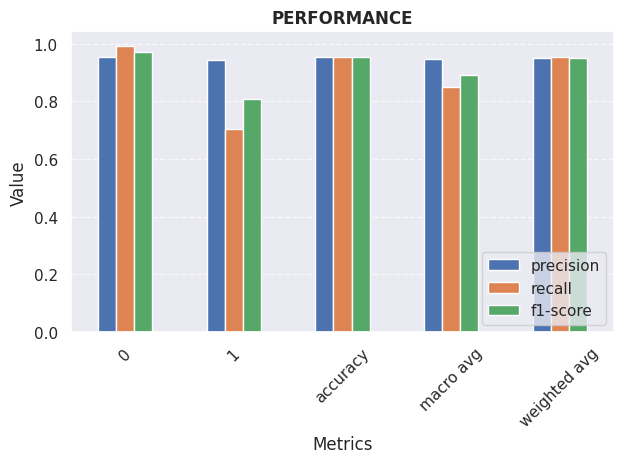

In [68]:
# Plot
plt.figure(figsize=(10, 6))
df_report.drop('support', axis=1).plot(kind='bar', rot=45)
plt.title('PERFORMANCE', fontsize=12, fontweight='bold')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

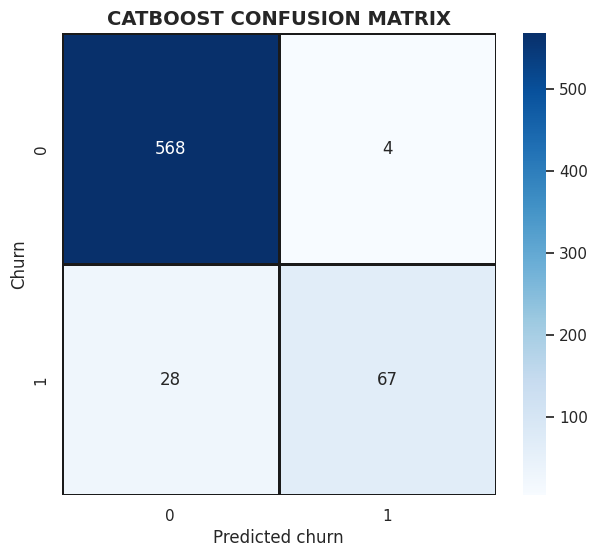

In [69]:
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_matrix(df_test['churn_encoder'], df_test['predict']),
            annot=True, fmt="d", linecolor="k", linewidths=1, cmap="Blues")

plt.title("CATBOOST CONFUSION MATRIX", fontsize=14, fontweight='bold')
plt.xlabel('Predicted churn')
plt.ylabel('Churn')
plt.show()
